In [1]:
%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [3]:
import os

from celerite import plot_setup
plot_setup.setup(auto=False)

from pylab import *
from pandas import DataFrame

import batman
import emcee3, corner
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

from astropy.io import fits
from glob import glob

from tqdm import tqdm_notebook
emcee3.samplers.tqdm_notebook = tqdm_notebook

from scipy.optimize import leastsq, minimize

from scipy.signal import medfilt
from scipy.stats import binned_statistic

from lmfit import Model, Parameters

from statsmodels.robust import scale
mad = scale.mad

from time import time

from sys import argv

from photutils import CircularAperture, CircularAnnulus, EllipticalAperture
from photutils import aperture_photometry

from statsmodels.robust import scale
from datetime import datetime

import jdcal
import datetime

from exoparams import PlanetParams

from numpy import cos, pi, abs

from sklearn.svm import SVR
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count

stdScaler = StandardScaler()
stime = time()

In [4]:
from ExoplanetTSO_Auxiliary import wanderer

In [5]:
from spitzer_helper_functions import clipOutliers, bin_array, b2inc, deltaphase_eclipse#, batman_lmfit_model, spiderman_lmfit_model
from spitzer_helper_functions import extract_PLD_components, de_median, savePickleOut

looking for spidermanrc file at /Users/jonathan/.spidermanrc
no spidermanrc file detected


In [6]:
print("\n**DONE LOADING LIBRARIES AND DEFINING FUNCTIONS**\n")


**DONE LOADING LIBRARIES AND DEFINING FUNCTIONS**



# Setup File System Usage

In [7]:
y,x         = 0,1
planetName  = 'planetName'
pwdSptzr    = '~/Research/Planets/'+planetName+'/analysis/'
saveDir     = 'SaveFiles/SaveState/' 

dataDir = os.environ['HOME'] + '/Research/Planets/'+planetName+'/data/'

**Load Planet Params**

In [8]:
planet_params = PlanetParams('Planet-Name b')

iPeriod   = planet_params.per.value
iTCenter  = planet_params.tt.value-2400000.5
iBImpact  = planet_params.b.value
iRsAp     = 1.0/planet_params.ar.value
iEdepth   = 200/1e6 # blind guess
iTdepth   = planet_params.depth.value
iEcc      = planet_params.ecc.value*0.0 # this is wrong, but we can work with it
iOmega    = planet_params.om.value*pi/180

In [9]:
stellar_radius = planet_params.rstar.value
stellar_temp   = planet_params.teff.value

**Load and Organize Data**

In [10]:
ppm             = 1e6
y,x             = 0,1

yguess, xguess  = 15., 15.   # Specific to Spitzer circa 2010 and beyond
filetype        = 'bcd.fits' # Specific to Spitzer Basic Calibrated Data

In [11]:
planetName      = 'PlanetName'
planetDirectory = '/Research/Planets/'

dataDir     = os.environ['HOME'] + planetDirectory + planetName + '/data/raw/'

# This is only a list as an example because it the following code can be used to combine multiple AORs
AORs    = ['r61524480', 'r61524736']#'r61523712', 'r61524224', 

channel = 'ch2/'

dataSub = 'bcd/'

fileExt = '*bcd.fits'
uncsExt = '*bunc.fits'

# iAOR        = 1
# AORNow      = AORs[iAOR]
# loadfitsdir = dataDir + AORNow + '/' + channel + dataSub
# print(loadfitsdir)

In [12]:
print('Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary')

planetName_wanderer_median_dict = {}
for AORNow in AORs:
    loadfitsdir         = dataDir + AORNow + '/' + channel + dataSub
    savefiledir         = os.environ['HOME']+'/Research/Planets/'+planetName+'/SaveFiles/'
    saveFileNameHeader  = planetName+'_'+ AORNow +'_Median'
    saveFileType        = '.pickle.save'

    print(savefiledir)
    print(saveFileNameHeader)
    print(saveFileType)

    method = 'median'

    print('Initialize an instance of `wanderer` as `example_wanderer_median`\n')
    planetName_wanderer_median_dict[AORNow] = wanderer(fitsFileDir=loadfitsdir, filetype=filetype, telescope='Spitzer',
                                                yguess=yguess, xguess=xguess, method=method, nCores=cpu_count())
    
    planetName_wanderer_median_dict[AORNow].load_data_from_save_files(savefiledir=savefiledir, 
                                                                  saveFileNameHeader=saveFileNameHeader, 
                                                                  saveFileType=saveFileType)

Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary
/Users/$USER/Research/Planets/PlanetName/SaveFiles/
PlanetName_r61524480_Median
.pickle.save
Initialize an instance of `wanderer` as `example_wanderer_median`



** Not all who wander are lost **


Completed Class Definition at 2017-11-13 15h44m4s
Loading from Master Files
nFrames False
Assigning Parts of `self.save_dict` to individual data structures
/Users/$USER/Research/Planets/PlanetName/SaveFiles/
PlanetName_r61524736_Median
.pickle.save
Initialize an instance of `wanderer` as `example_wanderer_median`



** Not all who wander are lost **


Completed Class Definition at 2017-11-13 15h44m5s
Loading from Master Files
nFrames False
Assigning Parts of `self.save_dict` to individual data structures


**Assign Tertiary Information**

In [13]:
aorName = 'r61524480'
q2dict = planetName_wanderer_median_dict[aorName]

In [14]:
AORNumberStack, timeCubeStack, imageCubeStack, noiseCubeStack, nTimeSkips       = {}, {}, {}, {}, {}
median_backgrounds, FWCStack, gaussianFits, photsStack, photsErrStack, nFrames  = {}, {}, {}, {}, {}, {}

key  = q2dict.flux_TSO_df.keys()[0]

nTimeSteps = 100
for kAOR, (aorName, q2dict) in enumerate(planetName_wanderer_median_dict.items()):
    q2dict.nFrames              = q2dict.imageCube.shape[0]
    nFrames[aorName]            = q2dict.nFrames
    AORNumberStack[aorName]     = [kAOR]*q2dict.nFrames
    timeCubeStack[aorName]      = q2dict.timeCube
    imageCubeStack[aorName]     = q2dict.imageCube
    noiseCubeStack[aorName]     = q2dict.noiseCube
    nTimeSkips[aorName]         = np.int(np.ceil(q2dict.nFrames/nTimeSteps))
    median_backgrounds[aorName] = q2dict.background_Annulus
    FWCStack[aorName]           = q2dict.centering_FluxWeight
    gaussianFits[aorName]       = q2dict.centering_GaussianFit
    photsStack[aorName]         = q2dict.flux_TSO_df[key]
    photsErrStack[aorName]      = np.sqrt(q2dict.flux_TSO_df[key])

/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


In [15]:
from ExoWandererAux import smooth_gaussconv

In [16]:
import batman

In [17]:
def lmfit_PLD_w_Ecl(period , tCenter , bImpact , rsap   , edepth  , tdepth  , ecc    , omega  ,
                pld1 , pld2  , pld3  , pld4 , pld5  , pld6  , pld7 , pld8 , pld9, intcpt, slope,
                times  , PLDFeatures, inliers, ldtype = 'uniform', transittype="primary"):
    
    if tdepth is not 0.0 or edepth is not 0.0:
        bm_params = batman.TransitParams() # object to store transit parameters
        
        aprs      = 1 / rsap
        
        bm_params.per       = period  # orbital period
        bm_params.t0        = tCenter # time of inferior conjunction
        bm_params.bImpact   = bImpact # b, impact parameter
        bm_params.r_a       = rsap  # RsAp
        bm_params.a         = aprs    # semi-major axis (in units of stellar radii)
        bm_params.fp        = edepth  # f
        bm_params.tdepth    = tdepth  # from Fraine et al. 2014s
        bm_params.rp        = sqrt(tdepth) # planet radius (in units of stellar radii)
        bm_params.ecc       = ecc     # eccentricity
        bm_params.w         = omega   # longitude of periastron (in degrees)
        bm_params.inc       = b2inc(bImpact, aprs, ecc, omega)*180/pi # orbital inclination (in degrees)
        bm_params.limb_dark = ldtype  # limb darkening model # NEED TO FIX THIS
        bm_params.u         = []      # limb darkening coefficients # NEED TO FIX THIS
        
        bm_params.delta_phase = deltaphase_eclipse(bm_params.ecc, bm_params.w)
        bm_params.t_secondary = bm_params.t0 + bm_params.per*bm_params.delta_phase
        
        m_eclipse = batman.TransitModel(bm_params, times[inliers], transittype=transittype).light_curve(bm_params)
    else:
        m_eclipse = 1.0
    
    if any(PLDCoeffs):
        PLDBaseline = dot(PLDFeatures[inliers], PLDCoeffs)
        
        return m_eclipse*PLDBaseline
    else:
        return m_eclipse * intcpt

# Clustering Analysis (DBSCAN) for Outlier Rejection

**Get rid of NaN phot values**

In [18]:
for aorName in gaussianFits.keys():
    keep  = np.isfinite(photsStack[aorName])
    gaussianFits[aorName]   = gaussianFits[aorName][keep]
    photsStack[aorName]     = photsStack[aorName][keep]
    photsErrStack[aorName]  = photsErrStack[aorName][keep]
    timeCubeStack[aorName]  = timeCubeStack[aorName][keep]
    imageCubeStack[aorName] = imageCubeStack[aorName][keep]

In [19]:
for i, (gFits, phots, photserr, times, images) in enumerate(zip(gaussianFits.values(), photsStack.values(), photsErrStack.values(), timeCubeStack.values(), imageCubeStack.values())):
    print(phots.shape, photserr.shape, gFits.shape, times.shape, images.shape)

(28222,) (28222,) (28222, 2) (28222,) (28222, 32, 32)
(39679,) (39679,) (39679, 2) (39679,) (39679, 32, 32)


**DBSCAN over Photometry with Y,X-Centers**

In [20]:
dbsPhots      = DBSCAN(n_jobs=-1)
dbsPhotsPred  = {}
inliersPhots  = {}

dbsClean  = 0

nSig = 5
for i,((aorName, gFits), phots) in enumerate(zip(gaussianFits.items(), photsStack.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    # keep   = np.isfinite(phots)

    # yctrs  = yctrs[keep]
    # xctrs  = xctrs[keep]
    # phots  = phots[keep]
    
    # print(yc.shape, xc.shape)
    featuresNow = np.transpose([stdScaler.fit_transform(yctrs[:,None]).ravel(), \
                             stdScaler.fit_transform(xctrs[:,None]).ravel(), \
                             stdScaler.fit_transform(phots[:,None]).ravel()])
    
    dbsPhotsPred[aorName] = dbsPhots.fit_predict(featuresNow)
    inliersPhots[aorName]  = dbsPhotsPred[aorName] == dbsClean

**Plot Photometry with Outliers**

DBSCAN found ~100 outliers per data set. This included some data points "inside" the bulk of the photometry. I am left to assume that because I did DBSCAN in 3 dimensions, that these data points were outliers in eithe the Y- or X- centerings.  We might possibly want to add noise pixels and gaussian widths to these lists.

r61524480 100 {0, 1, 2, 3, -1}
r61524736 136 {0, 1, -1}


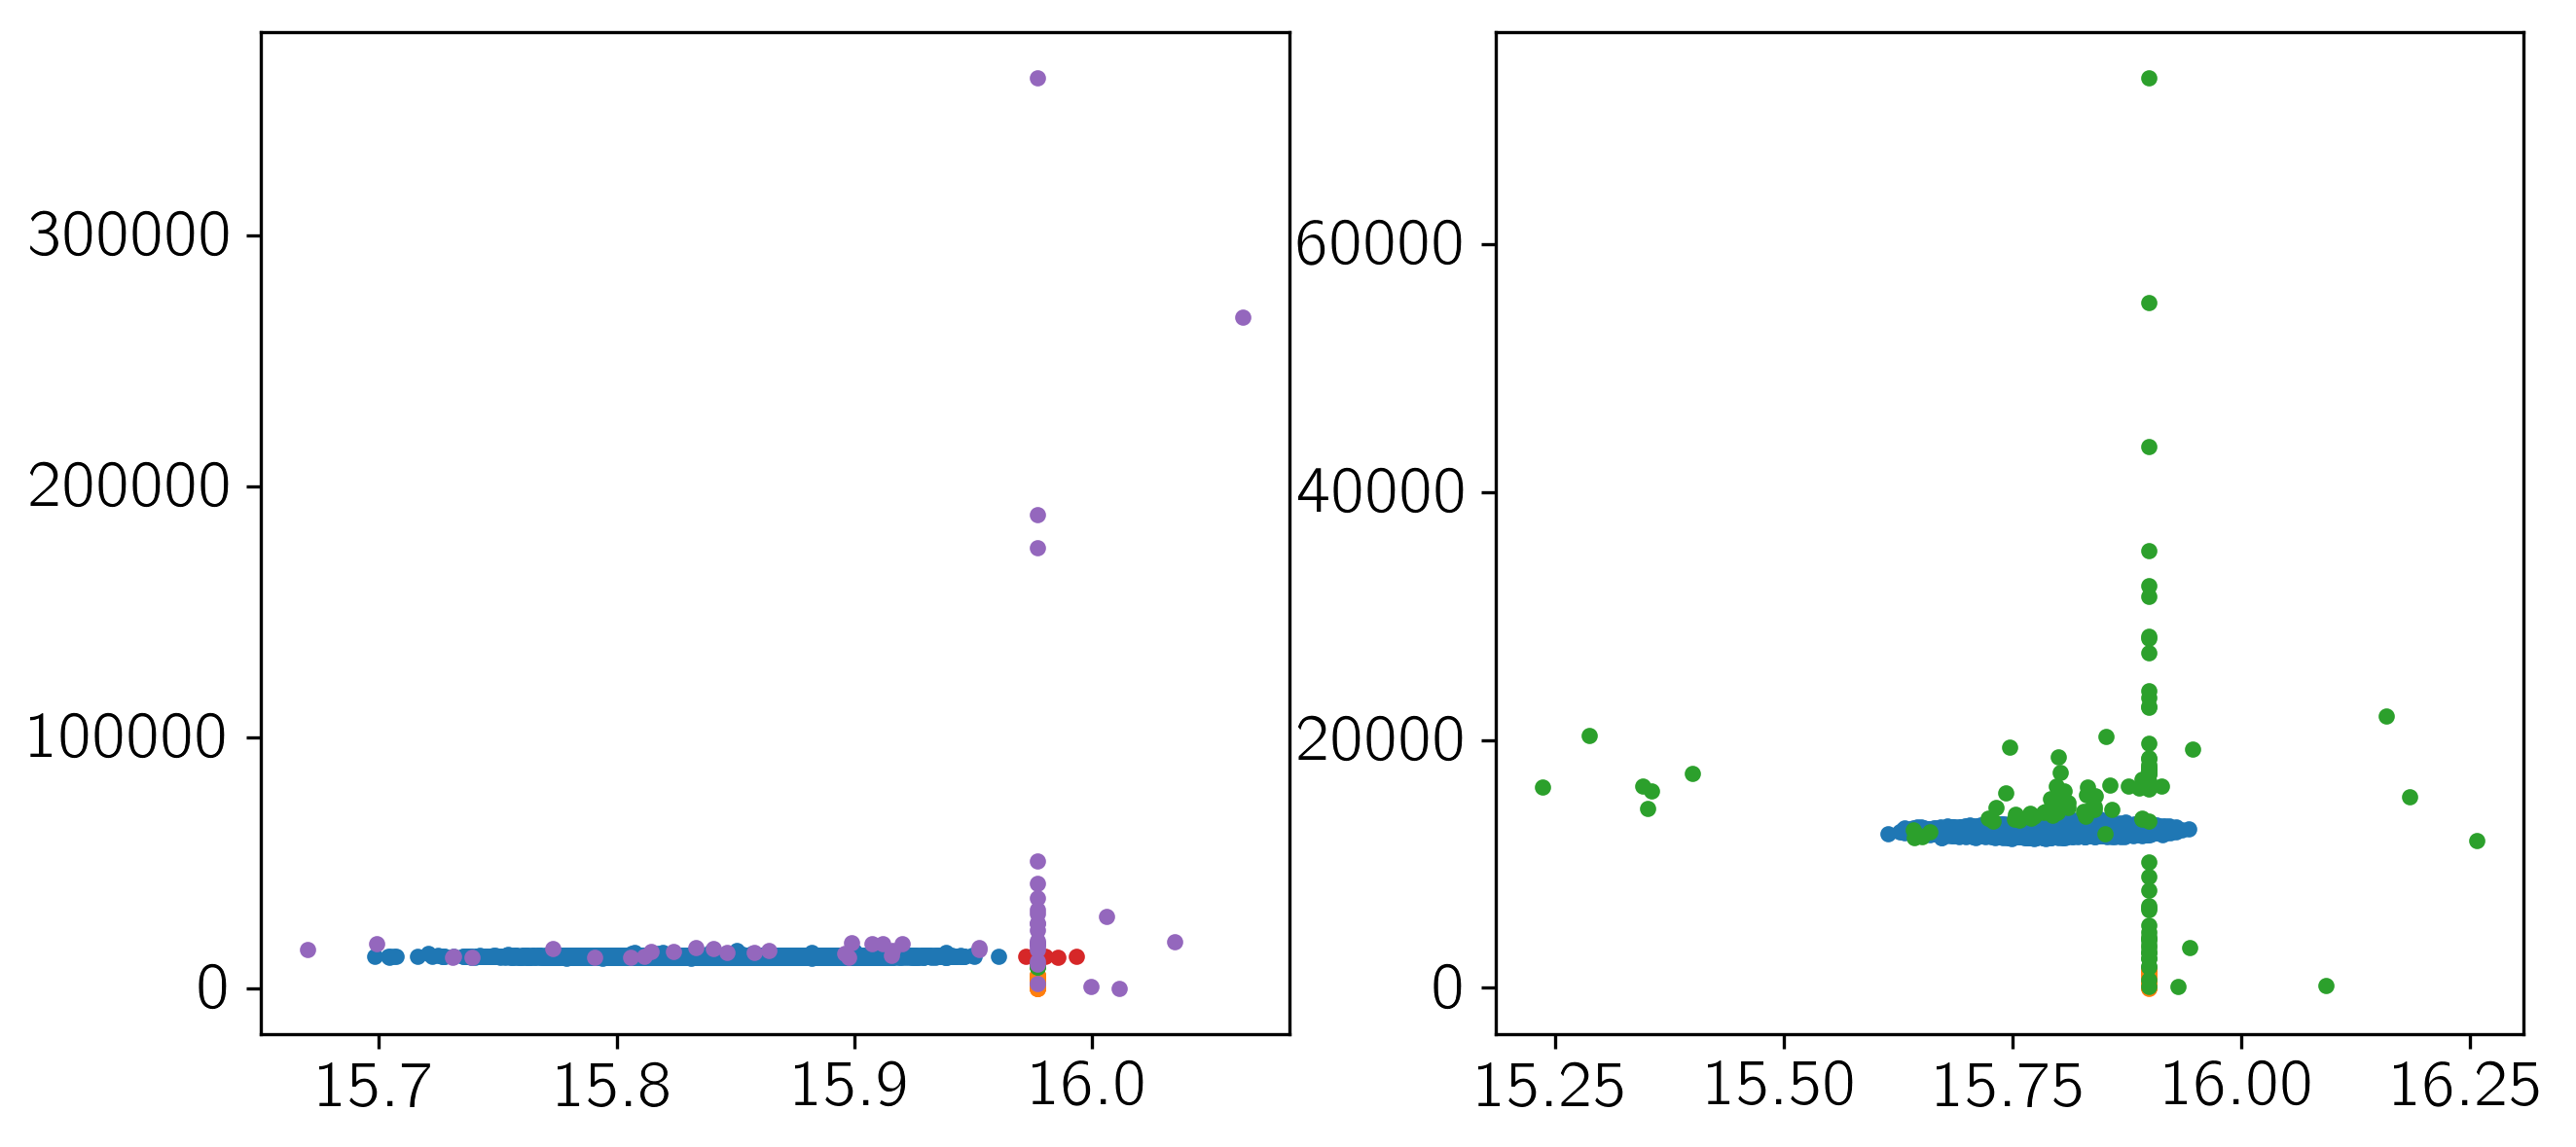

In [21]:
plt.figure(figsize=(10,10))

for i,((aorName, gFits), phots, dbsPred) in enumerate(zip(gaussianFits.items(), photsStack.values(), dbsPhotsPred.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    dbs_options = set(dbsPred)
    
    print(aorName, sum(dbsPred != list(dbs_options)[0]), dbs_options)
    
    # keep   = np.isfinite(phots)

    # yctrs  = yctrs[keep]
    # xctrs  = xctrs[keep]
    # phots  = phots[keep]
    
    subplot = plt.subplot(len(gaussianFits), 2, i + 1)
    for dbsOpt in dbs_options:
        if i+1%2:
            subplot.plot(yctrs[dbsPred==dbsOpt],phots[dbsPred==dbsOpt],'.', alpha=1)
        else:
            plot(xctrs[dbsPred==dbsOpt],phots[dbsPred==dbsOpt],'.', alpha=1)

**Plot Photometry for Inliers (non-Outliers) only**

r61524480 100 {0, 1, -1}
r61524736 136 {0, 1, -1}


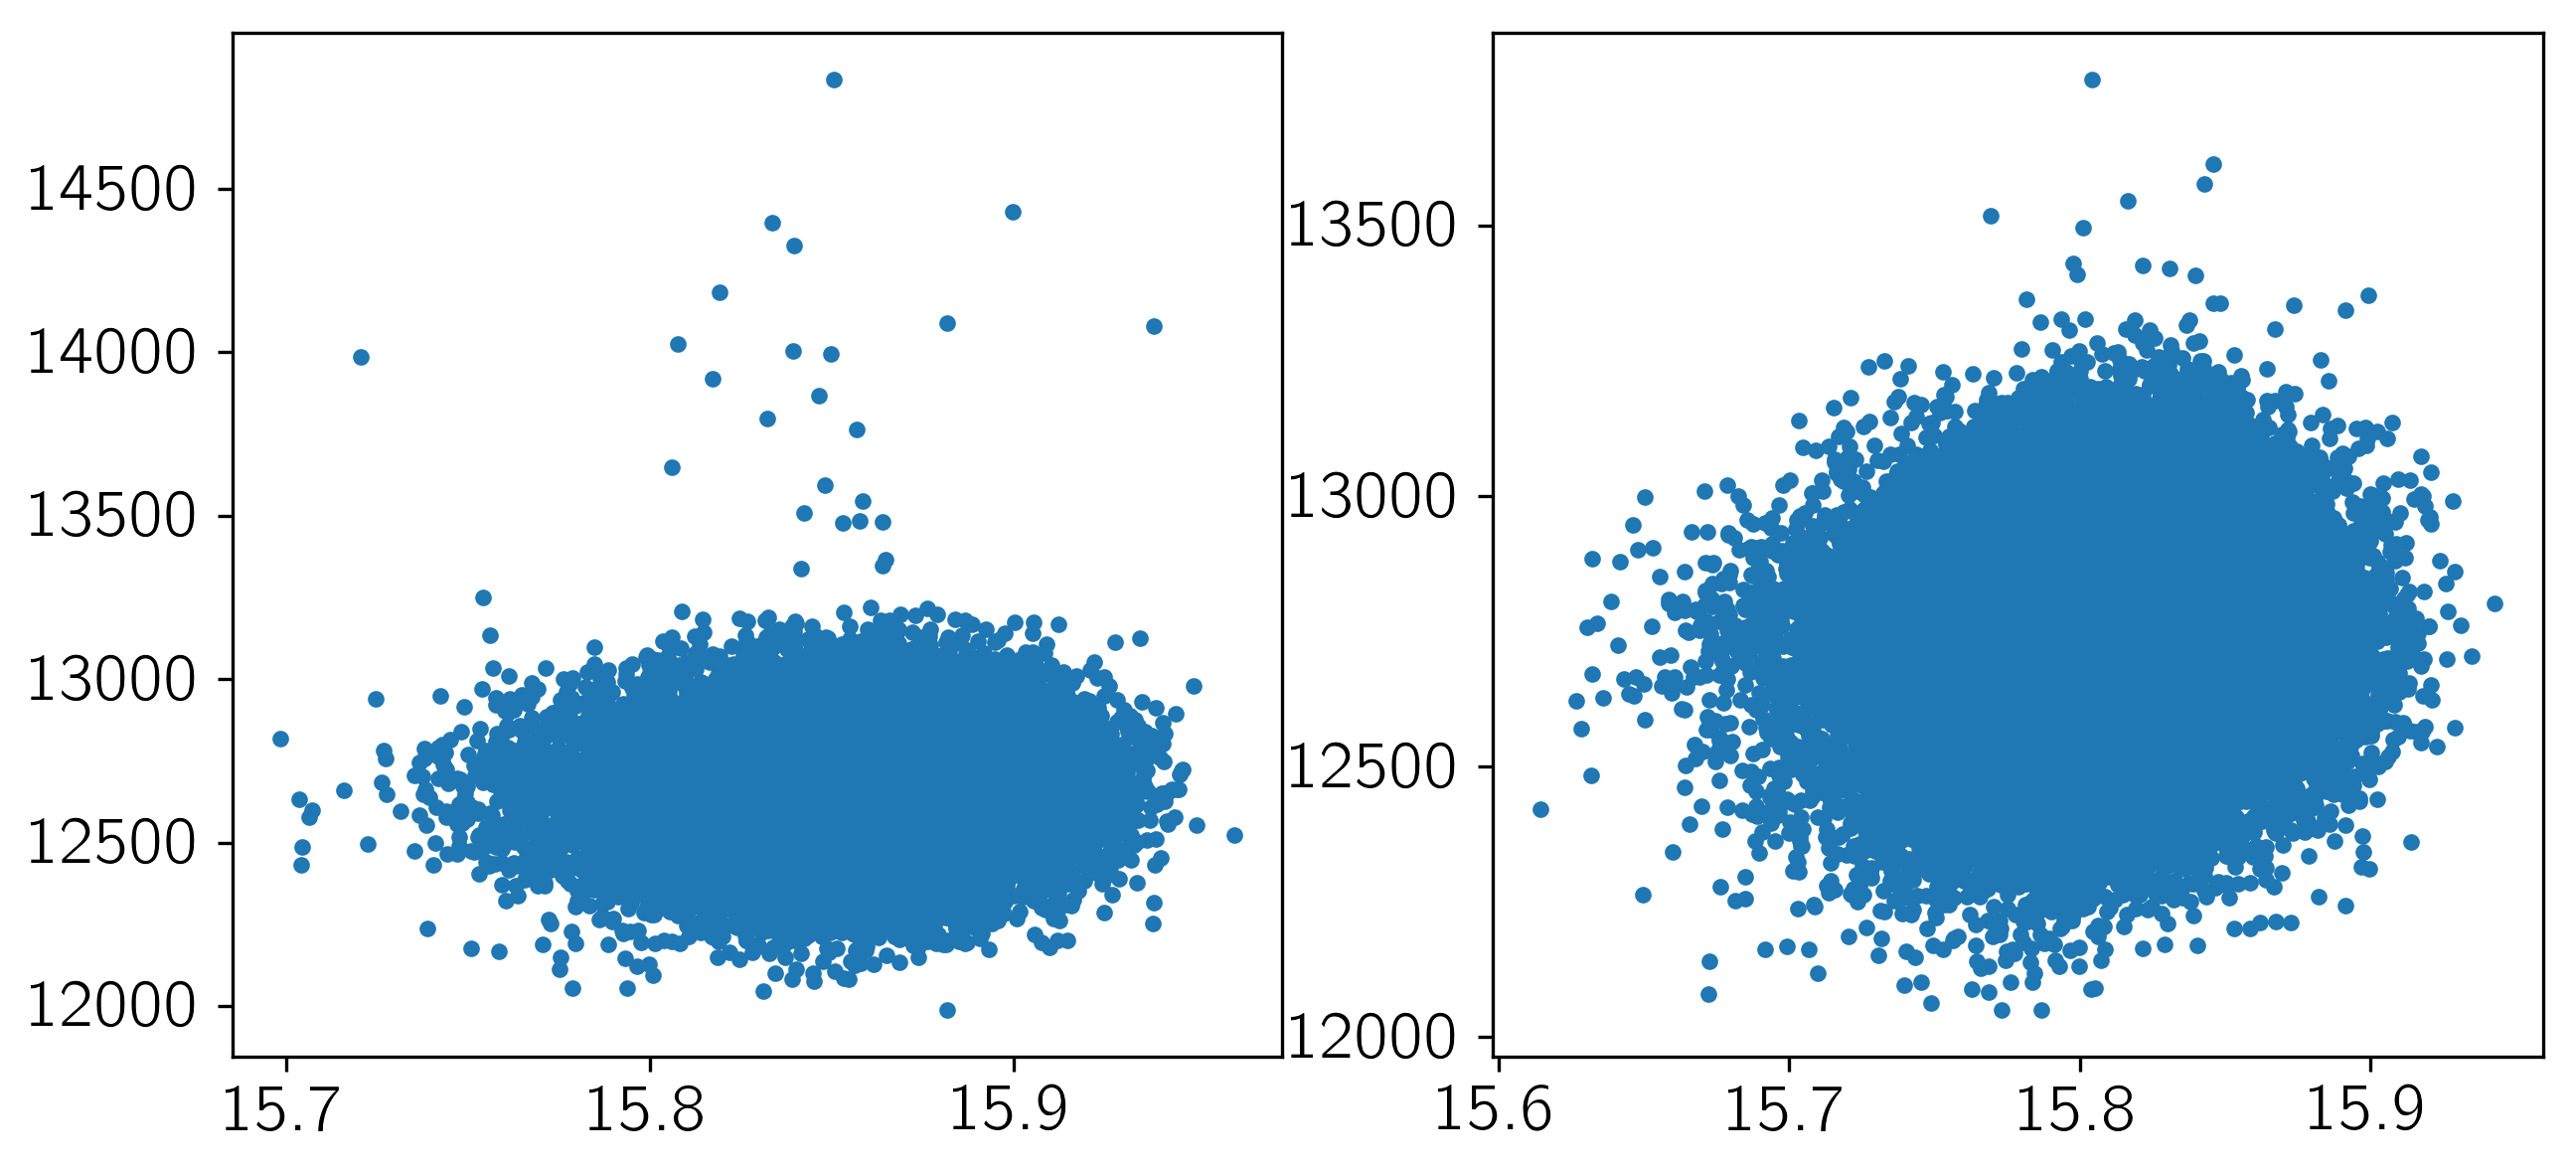

In [22]:
plt.figure(figsize=(10,10))

for i,((aorName, gFits), phots, useNow) in enumerate(zip(gaussianFits.items(), photsStack.values(), inliersPhots.values())):
    
    yctrs  = gFits.T[y]#['ycenter']
    xctrs  = gFits.T[x]#['xcenter']
    
    dbs_options = set(dbsPred)
    
    print(aorName, sum(phots.size - useNow.sum()), dbs_options)
    
    # keep   = np.isfinite(phots)

    # yctrs  = yctrs[keep]
    # xctrs  = xctrs[keep]
    # phots  = phots[keep]
        
    subplot = plt.subplot(len(gaussianFits), 2, i + 1)
    if i+1%2:
        subplot.plot(yctrs[useNow],phots[useNow],'.', alpha=1);
    else:
        plot(xctrs[useNow],phots[useNow],'.', alpha=1);

**Plot Full set of All Photometric Points, Both Before and After DBSCAN Outlier Rejection **

**Examine Binned Data for Correlation Visualization**

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

/Users/jonathan/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/jonathan/Research/github/ExoplanetTSO/spitzer_helper_functions.py:307: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  binArr  = mean(useArr.reshape(nCols, nRows),axis=1)
/Users/jonathan/Research/github/ExoplanetTSO/spitzer_helper_functions.py:308: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  stdArr  = std(useArr.reshape(nCols, nRows),axis=1) / sqrt(nSize)


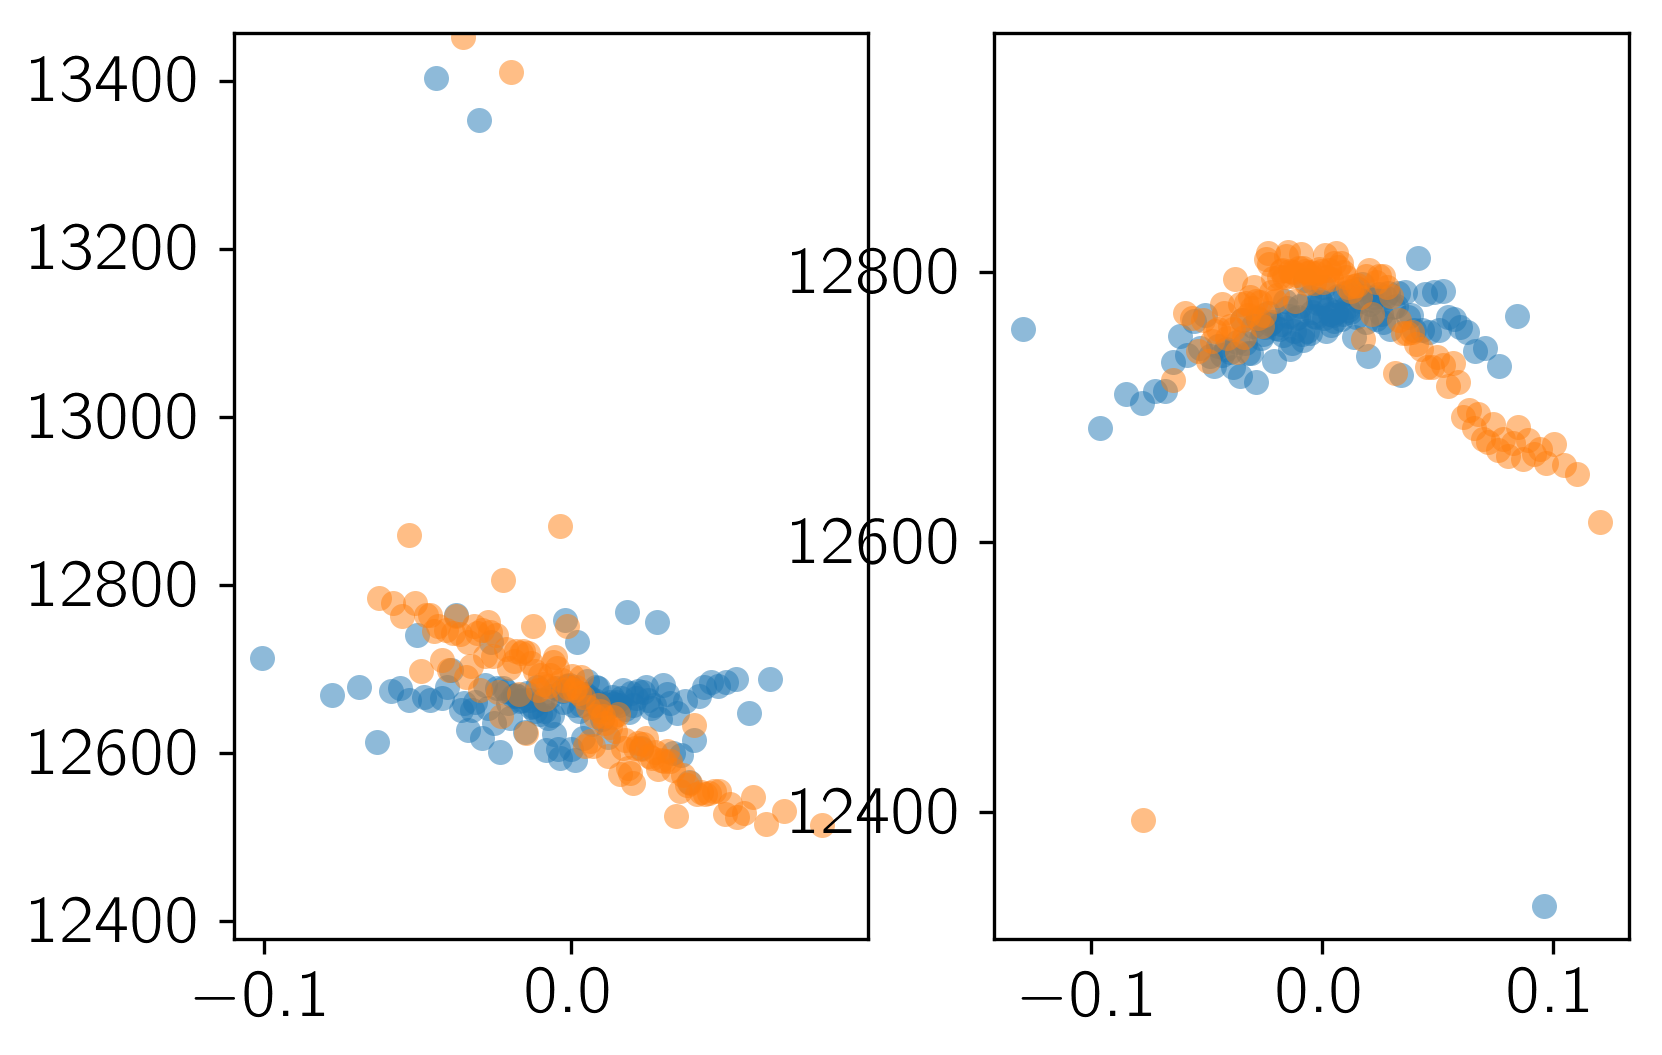

In [23]:
nbins   = 120
nWide   = 2
zipStack = zip(nFrames.items(), photsStack.values(), gaussianFits.values())
for kframe, ((aorName, nFs), phots, gaussian_fits) in tqdm_notebook(enumerate(zipStack), total=len(median_backgrounds)):
    binsize      = nFs // nbins
    
    # keep          = np.isfinite(phots)
    
    gcY           = gaussian_fits.T[y].copy()#['ycenter'].copy()
    gcX           = gaussian_fits.T[x].copy()#['xcenter'].copy()
    # phots         = phots[keep]
    
    Yc_argsort    = np.argsort(gcY)
    flux_sortedYc = phots[Yc_argsort]
    gcY_sortedYc  = gcY[Yc_argsort]
    
    Xc_argsort    = np.argsort(gcX)
    flux_sortedXc = phots[Xc_argsort]
    gcX_sortedXc  = gcX[Xc_argsort]
    
    bin_fluxY, bin_fluxY_err = bin_array(flux_sortedYc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_fluxX, bin_fluxX_err = bin_array(flux_sortedXc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_gcY, bin_gcYerr    = bin_array(gcY_sortedYc, uncs = None,  binsize=binsize, KeepTheChange = False)
    bin_gcX, bin_gcXerr    = bin_array(gcX_sortedXc, uncs = None,  binsize=binsize, KeepTheChange = False)
    
    plt.subplot(len(nFrames)//nWide, len(nFrames)//(len(nFrames)/nWide), kframe+1)
    plt.plot(bin_gcY-(median(gcY)), bin_fluxY,'o',alpha=0.5,mew=0);
    plt.plot(bin_gcX-(median(gcX)), bin_fluxX,'o',alpha=0.5,mew=0);
    
    plt.ylim(None, bin_fluxY.mean() + nSig*bin_fluxY.std())

** Plot Binned Y / X vs Flux Correlation**

# Identify Phase Coverage

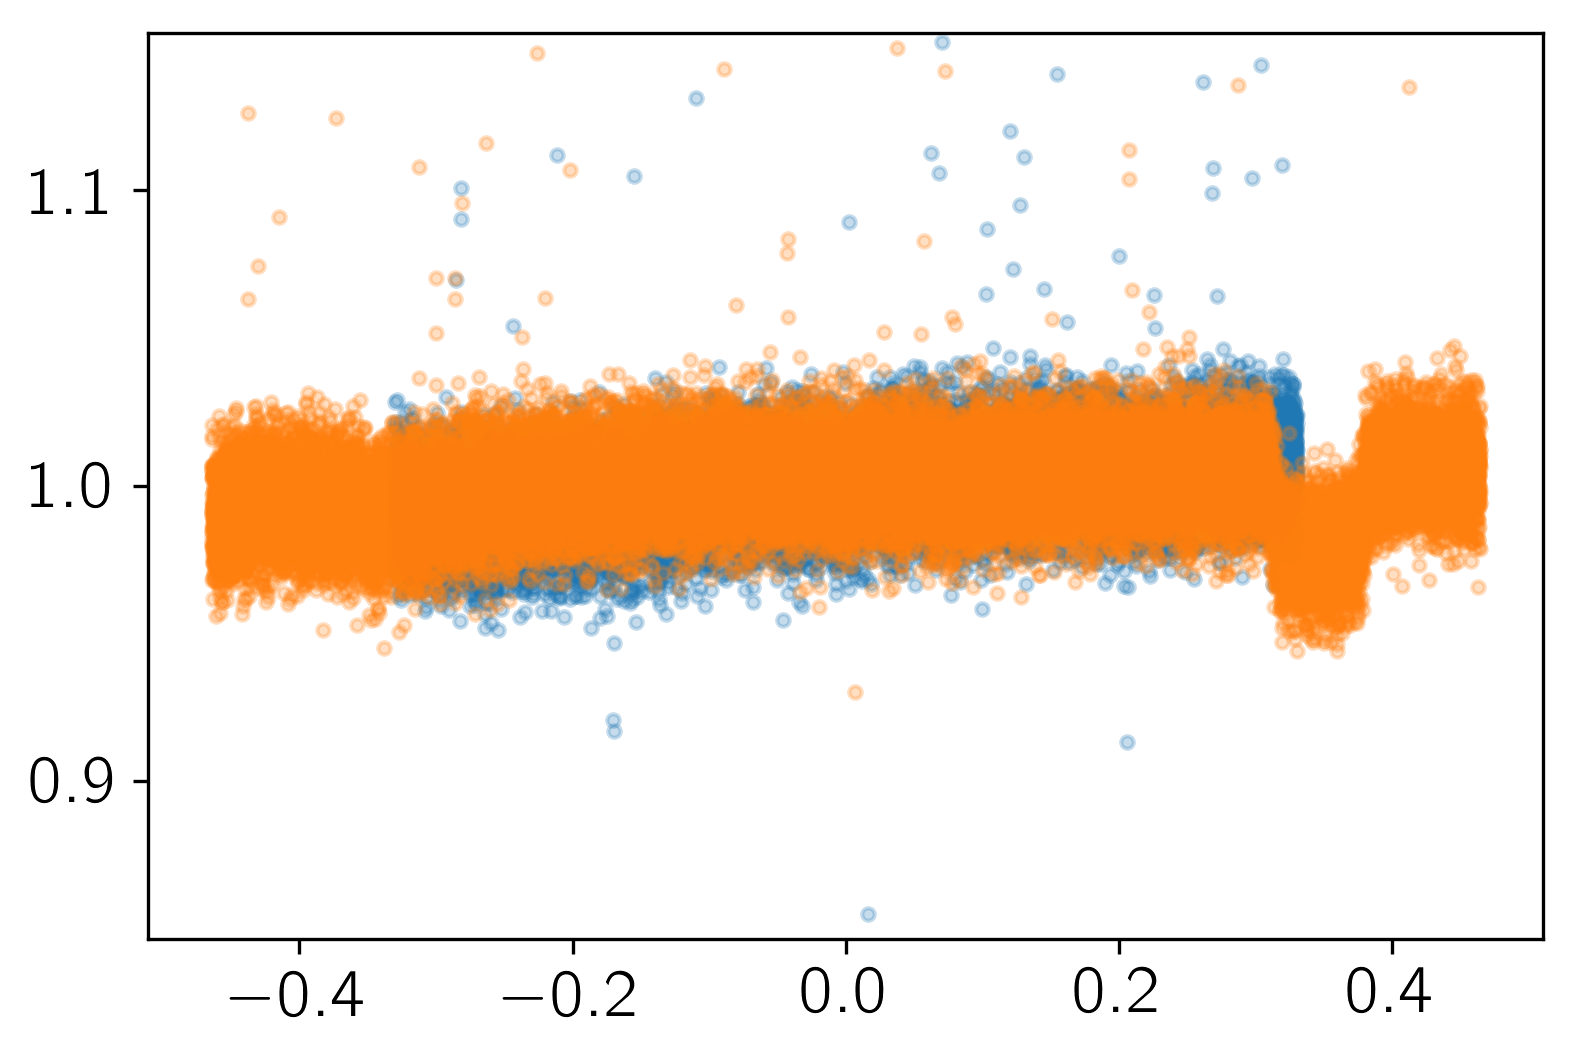

In [24]:
for times, phots in zip(timeCubeStack.values(), photsStack.values()):
    # keep  = np.isfinite(phots)
    # phots = phots[keep]
    # times = times[keep]
    
    plt.plot(times-times.mean(), phots / np.median(phots),'.', alpha=0.25)
    plt.ylim(1.0 - 3*(phots / np.median(phots)).std(),1.0 + 3*(phots / np.median(phots)).std())

**Compare Phase Coverage with Eclipse Models**

# Pixel Level Decorrelation

**Clip Outliers: DBSCAN PLD components in 1D to identify outliers**

In [25]:
PLDFeatureStack = {}

print('Looping over Channels and AORs')
for aorNow in AORs:
    PLDComponentsNow  = extract_PLD_components(imageCubeStack[aorNow])
    constantNow       = np.ones(timeCubeStack[aorNow].size)
    
    PLDFeatureStack[aorNow] = np.c_[PLDComponentsNow.T, constantNow, de_median(timeCubeStack[aorNow])]

Looping over Channels and AORs


In [26]:
dbsPLD  = DBSCAN(n_jobs=-1)
dbsPLDPred  = {}

dbsClean= 0

fig = plt.figure(figsize=(10,20))
for i,(aorName, PLD_components) in tqdm_notebook(enumerate(PLDFeatureStack.items()), 
                                                 total=len(PLDFeatureStack),
                                                 desc='AORs'):
    
    dbsPLDPred[aorName] = []
    for PLDComp in tqdm_notebook(PLD_components.T, total=len(PLD_components.T), desc='PLDComp ' + str(i)):
        featuresNow = stdScaler.fit_transform(PLDComp[:,None])
        dbsPLDPred[aorName].append(dbsPLD.fit_predict(featuresNow))
    
    dbsPLDPred[aorName] = np.array(dbsPLDPred[aorName])

HBox(children=(IntProgress(value=0, description='AORs', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PLDComp 0', max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, description='PLDComp 1', max=11), HTML(value='')))

In [27]:
inliersPLD = {}

for k,(aorName, dbsPLDNow) in enumerate(dbsPLDPred.items()):
    
    inliersPLD[aorName] = np.zeros(dbsPLDNow.shape, dtype=bool)
    
    for k, dbsPLDCompNow in enumerate(dbsPLDNow):
        inliersPLD[aorName][k]= dbsPLDCompNow == dbsClean

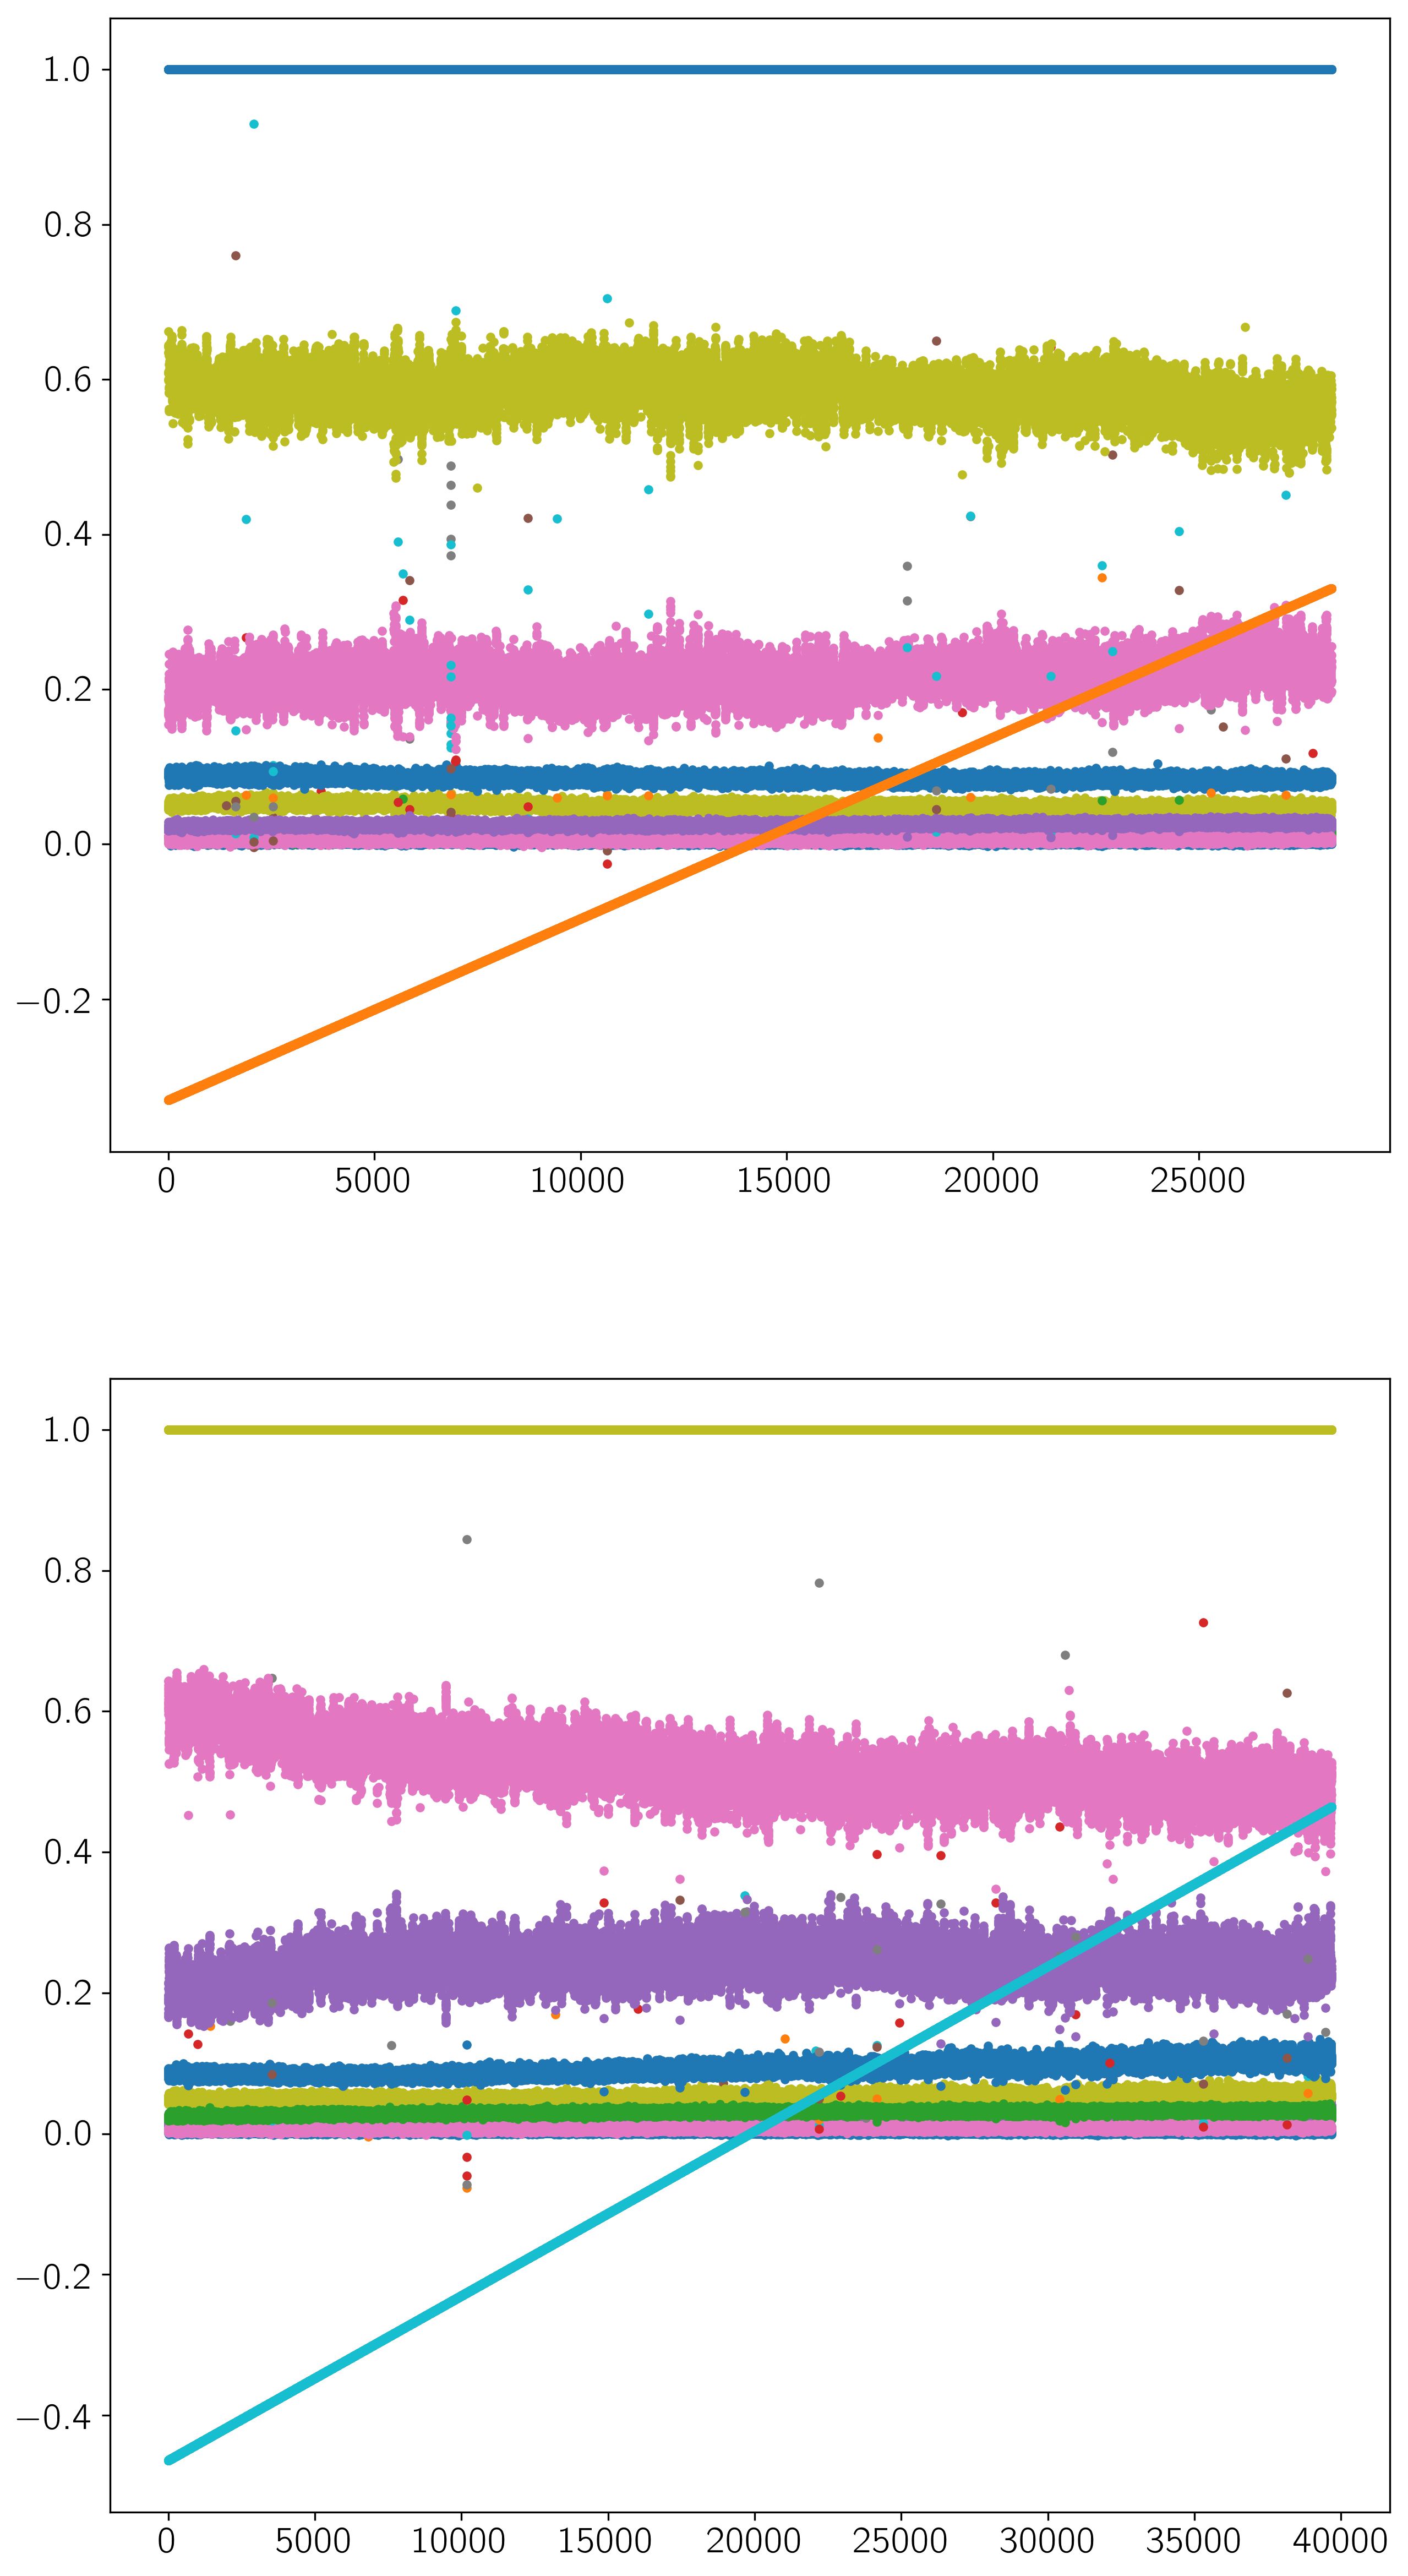

In [28]:
plt.figure(figsize=(10,20));
for i,(PLD_components, dbsPLDNow) in enumerate(zip(PLDFeatureStack.values(), dbsPLDPred.values())):
    plt.subplot(len(PLDFeatureStack), 1, i+1);
    for k, PLDComp in enumerate(PLD_components.T):
        for dbsOpt in set(dbsPLDNow[k]):
            plot(np.arange(PLDComp.size)[dbsPLDNow[k] == dbsOpt], PLDComp[dbsPLDNow[k] == dbsOpt],'.');

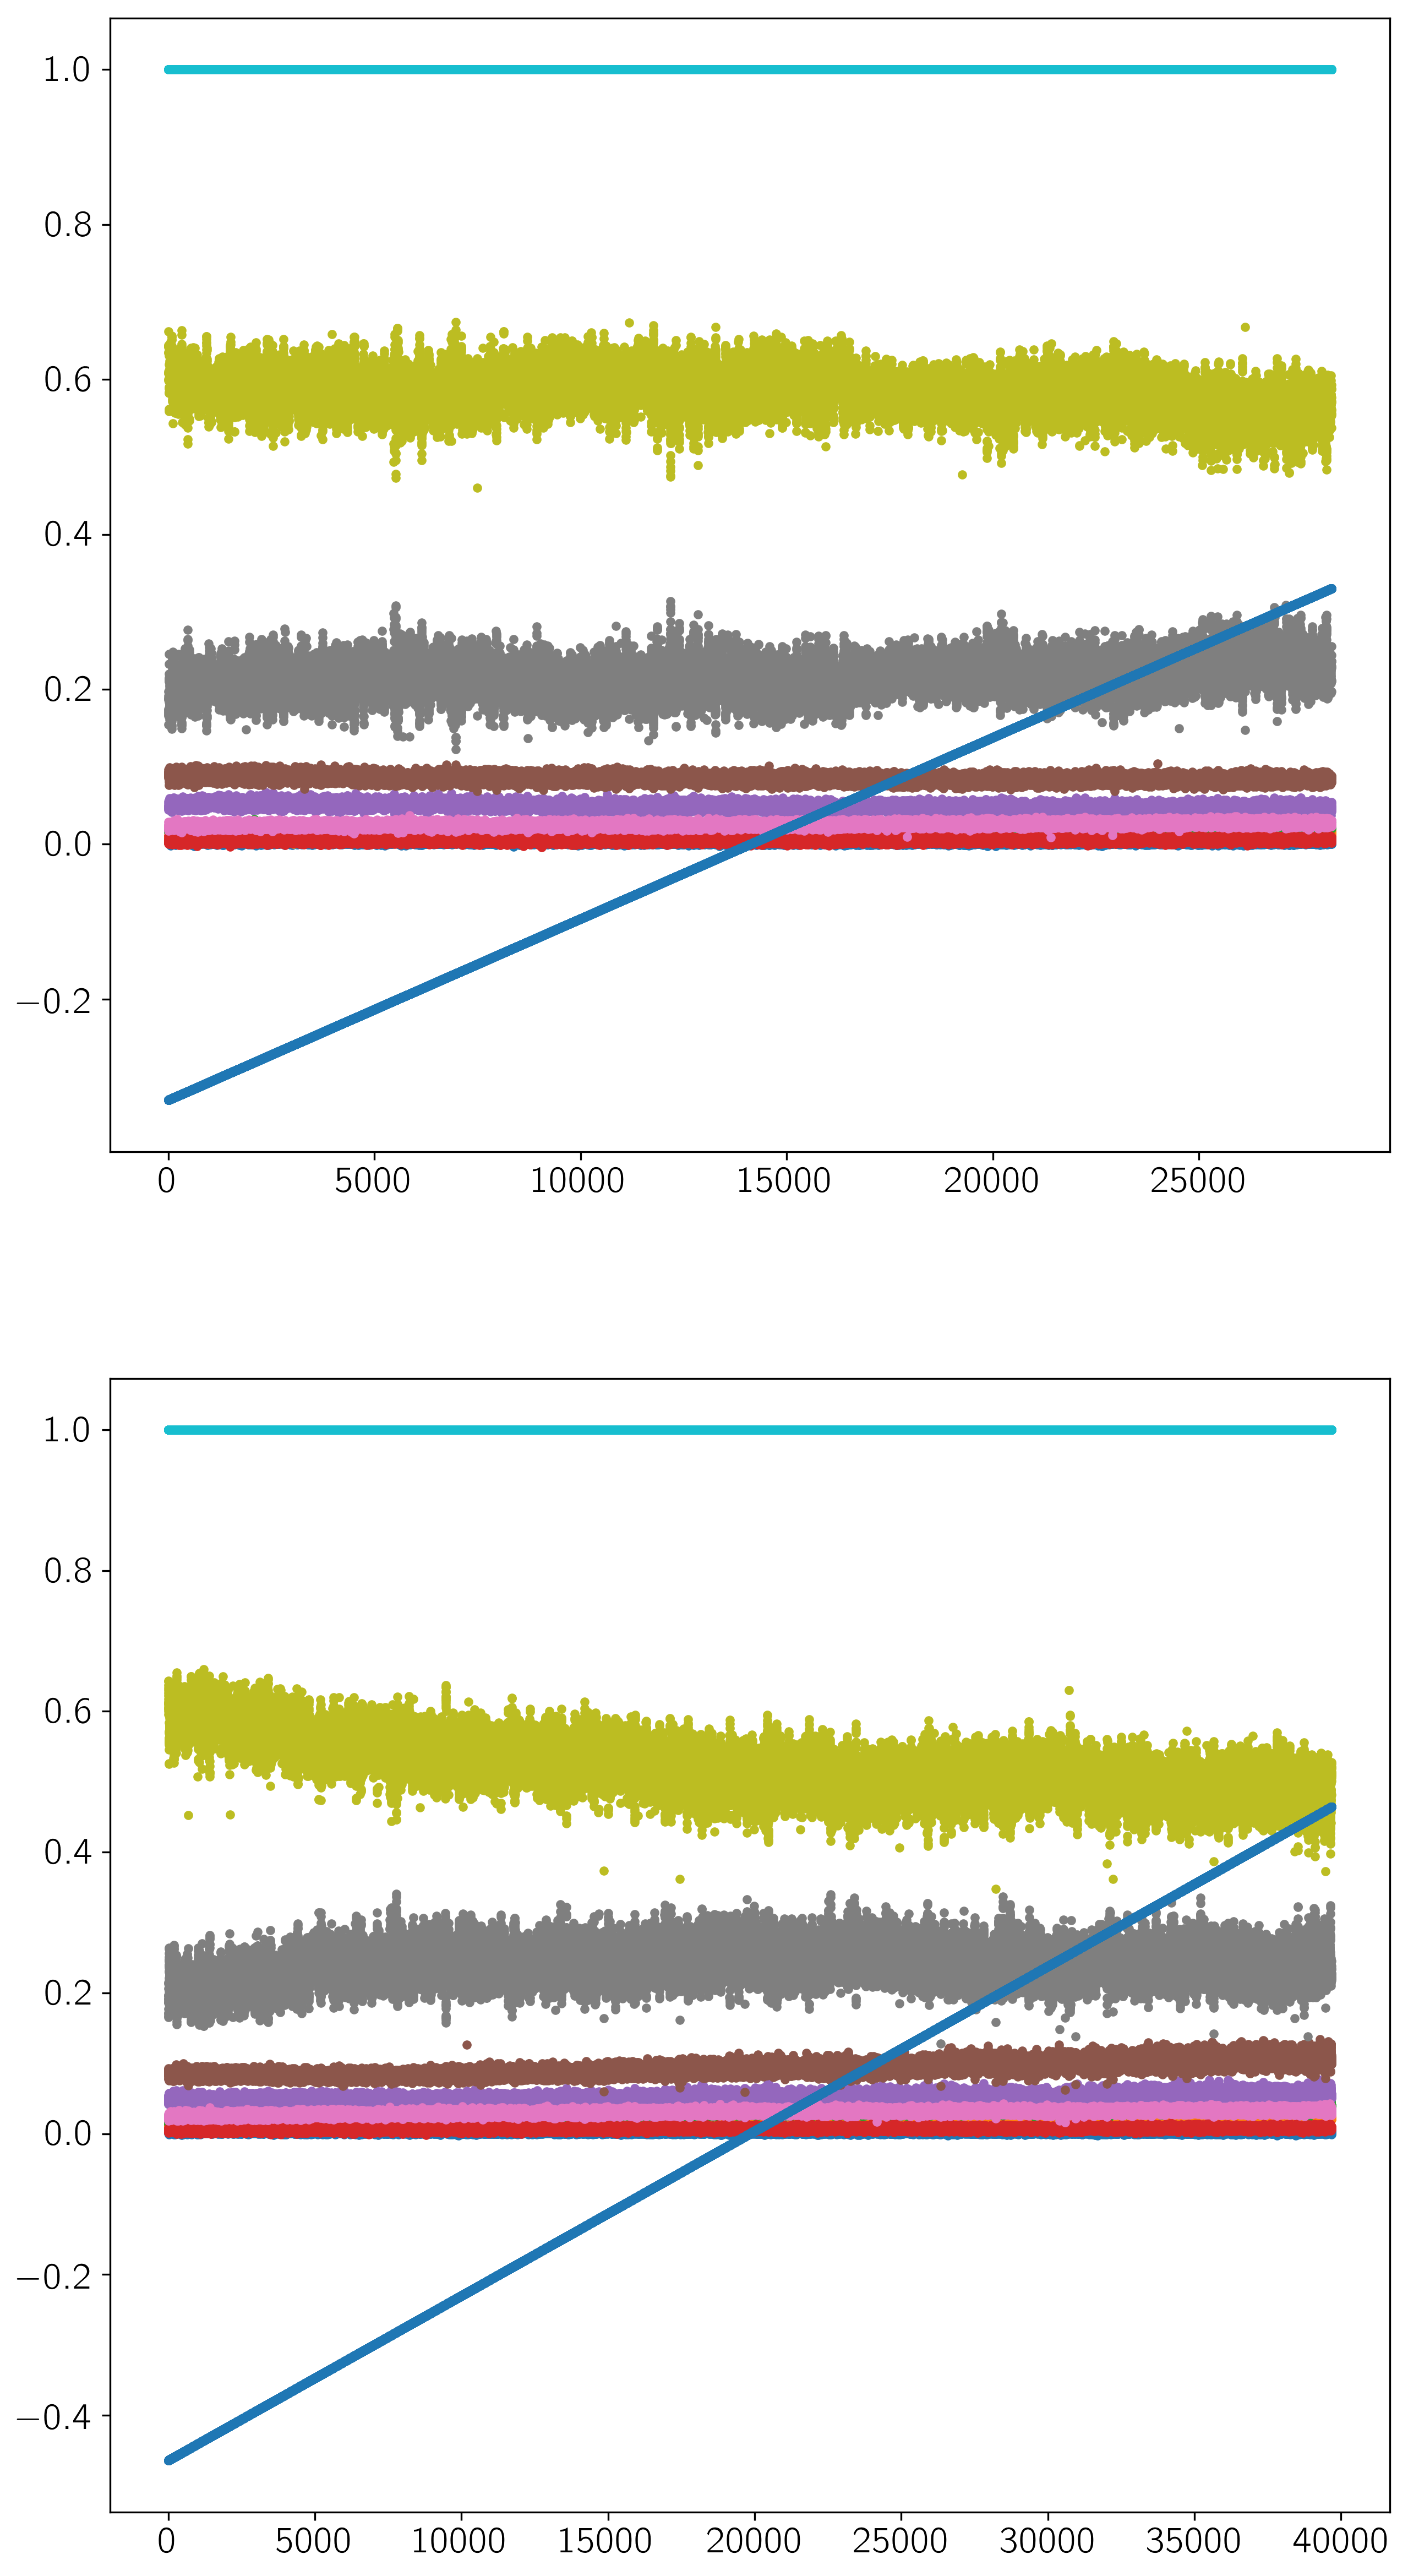

In [29]:
plt.figure(figsize=(10,20));
for i,(PLD_components, inliersNow) in enumerate(zip(PLDFeatureStack.values(), inliersPLD.values())):
    plt.subplot(len(PLDFeatureStack), 1, i+1);
    for k, (PLDComp, inlierComp)in enumerate(zip(PLD_components.T, inliersNow)):
        plot(np.arange(PLDComp.size)[inlierComp], PLDComp[inlierComp],'.');

**Combine all Inlier Arrays to Create Master Inliers**

All of the photometry, time, centering, and PLD components need to have the same indexing and size.

In [30]:
inliersMaster = {}
for k, ((aorName, inliersPhot), inlierPLDNow)  in enumerate(zip(inliersPhots.items(), inliersPLD.values())):
    inliersMaster[aorName] = inliersPhot.copy()
    for inlierPLDComp in inlierPLDNow:
        inliersMaster[aorName] = inliersMaster[aorName] * inlierPLDComp

# Identify Grid Search Paramters

Here we are picking how many grid steps to select (n=100) and compute the number of skipped time coordinates

In [31]:
nTimeSteps = 100
nTimeSkips = np.zeros(len(timeCubeStack), dtype=int)
for k, timeCube in enumerate(timeCubeStack.values()):
    nTimeSkips[k] = np.int(np.ceil(timeCube.size/nTimeSteps))

nTimeSkips

array([283, 397])

**Save After PLD Components' DBSCANs**

In [32]:
save_pickle_dict = {'dataDir':dataDir, 
                    'AORNumberStack':AORNumberStack,
                    'timeCubeStack':timeCubeStack, 
                    'imageCubeStack':imageCubeStack, 
                    'noiseCubeStack':noiseCubeStack, 
                    'nFrames':nFrames, 
                    'nTimeSkips':nTimeSkips,
                    'median_backgrounds':median_backgrounds, 
                    'FWCStack':FWCStack, 
                    'gaussianFits':gaussianFits,
                    'PLDFeatureStack':PLDFeatureStack,
                    'photsStack':photsStack, 
                    'photsErrStack':photsErrStack,
                    'dbsPhotsPred':dbsPhotsPred,
                    'inliersPhots':inliersPhots,
                    'dbsPLDPred':dbsPLDPred,
                    'inliersPLD':inliersPLD,
                    'inliersMaster':inliersMaster
                    }

lastSavedFile = savePickleOut(save_pickle_dict, header=planetName, stacked=True)

FileNotFoundError: [Errno 2] No such file or directory: 'SaveFiles/SaveState/'

In [ ]:
photsFlatten    = []
photsPhLimFlat  = []
photsErrFlatten = []
timesFlatten    = []
inliersFlatten  = []
for k, (times, phots, photsErr, inliersMast) in enumerate(zip(timeCubeStack.values(), 
                                                              photsStack.values(), 
                                                              photsErrStack.values(),
                                                              inliersMaster.values())):
    
    photsFlatten    = photsFlatten   + list(phots[inliersMast]    / np.median(phots[inliersMast]))
    photsPhLimFlat  = photsPhLimFlat + list(sqrt(phots[inliersMast])/ np.median(phots[inliersMast]))
    photsErrFlatten = photsErrFlatten+ list(photsErr[inliersMast] / np.median(phots[inliersMast]))
    timesFlatten    = timesFlatten   + list(times[inliersMast])
    inliersFlatten  = inliersFlatten + list(inliersMast)

photsFlatten    = np.array(photsFlatten)
photsPhLimFlat  = np.array(photsPhLimFlat)
photsErrFlatten = np.array(photsErrFlatten)
timesFlatten    = np.array(timesFlatten)
inliersFlatten  = np.array(inliersFlatten)

**Initialize LMFIT Parameters and Model**

In [ ]:
def batman_lmfit_model(period, tCenter, bImpact, rsap, edepth, tdepth, ecc, omega, times, 
                       ldtype = 'uniform', transittype="primary"):#, bm_params=None):
    
    if tdepth is not 0.0 or edepth is not 0.0:
        # if bm_params is None:
        #     bm_params = batman.TransitParams() # object to store transit parameters
        
        aprs      = 1 / rsap
        
        bm_params.per       = period  # orbital period
        bm_params.t0        = tCenter # time of inferior conjunction
        bm_params.bImpact   = bImpact # b, impact parameter
        bm_params.r_a       = rsap  # RsAp
        bm_params.a         = aprs    # semi-major axis (in units of stellar radii)
        bm_params.fp        = edepth  # f
        bm_params.tdepth    = tdepth  # from Fraine et al. 2014s
        bm_params.rp        = sqrt(tdepth) # planet radius (in units of stellar radii)
        bm_params.ecc       = ecc     # eccentricity
        bm_params.w         = omega   # longitude of periastron (in degrees)
        bm_params.inc       = b2inc(bImpact, aprs, ecc, omega)*180/pi # orbital inclination (in degrees)
        bm_params.limb_dark = ldtype  # limb darkening model # NEED TO FIX THIS
        bm_params.u         = []      # limb darkening coefficients # NEED TO FIX THIS
        
        bm_params.delta_phase = deltaphase_eclipse(bm_params.ecc, bm_params.w)
        bm_params.t_secondary = bm_params.t0 + bm_params.per*bm_params.delta_phase
        
        m_eclipse = batman.TransitModel(bm_params, times, transittype=transittype).light_curve(bm_params)
    else:
        return ones(times.size)
    
    return m_eclipse

import spiderman as sp
from astropy.constants import R_sun, au
def spiderman_lmfit_model(period, tCenter, bImpact, rsap, tdepth, ecc, omega, times, 
                          u1=0.0, u2=0.0, xi=0.3, T_night=1128, delta_T=942):
    
    if tdepth is not 0.0 or edepth is not 0.0:
        aprs  = 1 / rsap
        a_au  = aprs * spider_params.stellar_radius * R_sun.value / au.value
        
        spider_params.t0      = tCenter      # Central time of PRIMARY transit [days]
        spider_params.per     = period       # Period [days]
        spider_params.a_abs   = a_au         # The absolute value of the semi-major axis [AU]
        spider_params.inc     = b2inc(bImpact, aprs, ecc, omega)*180/pi # orbital inclination (in degrees)
        spider_params.ecc     = ecc          # Eccentricity
        spider_params.w       = omega        # Argument of periastron
        spider_params.rp      = sqrt(tdepth) # planet radius (in units of stellar radii)
        spider_params.a       = aprs         # Semi-major axis scaled by stellar radius
        spider_params.p_u1    = u1           # Planetary limb darkening parameter
        spider_params.p_u2    = u2           # Planetary limb darkening parameter
        
        spider_params.xi      = xi           # Ratio of radiative to advective timescale             
        spider_params.T_n     = T_night      # Temperature of nightside
        spider_params.delta_T = delta_T      # Day-night temperature contrast
        
        model_pc  = spider_params.lightcurve(times)
        
        return model_pc
    else:
        return ones(times.size)
    
    raise Exception('Something Weird happened')

In [ ]:
def phase_curve_lmfit_model(period, tCenter, bImpact, rsap, tdepth, ecc, omega, u1, u2, xi, T_night, delta_T, 
                                     pld1_0, pld2_0, pld3_0, pld4_0, pld5_0, pld6_0, pld7_0, pld8_0, pld9_0, 
                                     pld1_1, pld2_1, pld3_1, pld4_1, pld5_1, pld6_1, pld7_1, pld8_1, pld9_1, 
                                     intcpt_0, slope_0, intcpt_1, slope_1, times_0, times_1, PLDFeatures_0, 
                                     PLDFeatures_1):
    
    eclipse_depth = 0.0 # necessary to multiply spiderman and batman
    
    PLDCoeffs_0   = [pld1_0, pld2_0, pld3_0, pld4_0, pld5_0, pld6_0, pld7_0, pld8_0, pld9_0, intcpt_0, slope_0]
    PLDCoeffs_1   = [pld1_1, pld2_1, pld3_1, pld4_1, pld5_1, pld6_1, pld7_1, pld8_1, pld9_1, intcpt_1, slope_1]
    
    instrumental_0= dot(PLDFeatures_0,PLDCoeffs_0)
    instrumental_1= dot(PLDFeatures_1,PLDCoeffs_1)
    
    times         = np.c_[[times_0], [times_1]].flatten()
    instrumental  = np.c_[[instrumental_0], [instrumental_1]].flatten()
    
    phase_curve   = spiderman_lmfit_model(period=period, tCenter=tCenter, bImpact=bImpact, rsap=rsap, 
                                          tdepth=tdepth, ecc=ecc, omega=omega, times=times, u1=u1, u2=u2, 
                                          xi=xi, T_night=T_night, delta_T=delta_T)
    
    transit       = batman_lmfit_model(period=period, tCenter=tCenter, bImpact=bImpact, rsap=rsap, 
                                       edepth=eclipse_depth, tdepth=tdepth, ecc=ecc, omega=omega, times=times)
    
    # print(np.isnan(instrumental).sum(), np.isnan(transit).sum(), np.isnan(phase_curve).sum())
    return instrumental * transit * phase_curve

In [ ]:
u1_0, u2_0, xi_0, T_night_0, delta_T_0 = 0.1, 0.1, 0.1, 1000, 1000

initialParamsFull_PhaseCurve = Parameters()

initialParamsFull_PhaseCurve.add_many(
    # Planetary Paramters
    ('period' , iPeriod   , False ),
    ('tCenter', iTCenter  , True ), 
    ('bImpact', iBImpact  , True , -1.0, 1.0 ),
    ('rsap'   , iRsAp     , True , 0.0 , 1.0 ),
    ('tdepth' , iTdepth   , True  , 0.0 , 1.0 ),
    ('ecc'    , iEcc      , False, 0.0 , 1.0 ),
    ('omega'  , iOmega    , False , 0.0 , 360.),
    ('u1'     , u1_0      , True , 0.0 , 1.0),
    ('u2'     , u2_0      , True , 0.0 , 1.0),
    ('xi'     , xi_0      , True , 0.0 , 1.0),
    ('T_night', T_night_0 , True , 0.0 , 2000.),
    ('delta_T', delta_T_0 , True , 0.0 , 2000.),
    
    # PLD Coefficients for the 0th AOR
    ('pld1_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld2_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld3_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld4_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld5_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld6_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld7_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld8_0' , 1.0     , True  , -1.0 , 1.0),
    ('pld9_0' , 1.0     , True  , -1.0 , 1.0),
    
    # PLD Coefficients for the 1st AOR
    ('pld1_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld2_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld3_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld4_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld5_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld6_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld7_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld8_1' , 1.0     , True  , -1.0 , 1.0),
    ('pld9_1' , 1.0     , True  , -1.0 , 1.0),
    
    # Out of transit linear baselines
    ('intcpt_0' , 1.0     , True) ,
    ('slope_0'  , 1e-6    , True) ,
    ('intcpt_1' , 1.0     , True) ,
    ('slope_1'  , 1e-6    , True))

lcFull_PhaseCurve = Model(phase_curve_lmfit_model, 
                          independent_vars = ['times_0', 'times_1',  'PLDFeatures_0', 'PLDFeatures_1'])

n_layers      = 20
sptzr_ch2_l1 = 4e-6
sptzr_ch2_l2 = 5e-6

bm_params     = batman.TransitParams()
spider_params = sp.ModelParams(brightness_model='zhang')
spider_params.n_layers       = n_layers
spider_params.stellar_radius = planetName_radius
spider_params.T_s = planetName_temp
spider_params.l1  = sptzr_ch2_l1
spider_params.l2  = sptzr_ch2_l2

In [ ]:
aor_0, aor_1     = timeCubeStack.keys()
times_0, times_1 = timeCubeStack.values()
PLDFeatures_0, PLDFeatures_1 = PLDFeatureStack.values()

times_0 = times_0[inliersMaster[aor_0]]
times_1 = times_1[inliersMaster[aor_1]]

PLDFeatures_0 = PLDFeatures_0[inliersMaster[aor_0]]
PLDFeatures_1 = PLDFeatures_1[inliersMaster[aor_1]]

stime1 = time()
fitResults_Full_PhaseCurve = lcFull_PhaseCurve.fit(photsFlatten / np.median(photsFlatten),
                                                     weights       = 1.0 / abs(photsFlatten), #photsErrFlatten**2.,
                                                     params        = initialParamsFull_PhaseCurve,
                                                     method        = 'leastsq',
                                                     times_0       = times_0, 
                                                     times_1       = times_1, 
                                                     PLDFeatures_0 = PLDFeatures_0,
                                                     PLDFeatures_1 = PLDFeatures_1)

print('Operation took {} seconds'.format(time() - stime1))

# OLD
**PLD Individual and Combine**

In [ ]:
initialParamsAORCircle = {}
lcAORCircle            = {}

for aorName in timeCubeStack.keys():
    initialParamsAORCircle[aorName] = Parameters()
    
    initialParamsAORCircle[aorName].add_many(
        # Planetary Paramters
        ('period' , iPeriod , False ),
        ('tCenter', iTCenter, False ), # temporary fix because I fixed a type above; but not fully.
        ('bImpact', iBImpact, False , -1.0, 1.0 ),
        ('rsap'   , iRsAp   , False , 0.0 , 1.0 ),
        ('edepth' , iEdepth , True , 0.0 , 1.0 ),
        ('tdepth' , iTdepth , False  , 0.0 , 1.0 ),
        ('ecc'    , 0.0     , False, 0.0 , 1.0 ), # circular orbit
        ('omega'  , iOmega  , False , 0.0 , 360.),

        # PLD Coefficients for the 0th AOR
        ('pld1_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_0' , 1.0     , True  , -1.0 , 1.0),

        # Out of transit linear baselines
        ('intcpt_0' , 1.0     , True) ,
        ('slope_0'  , 1e-6    , True)
        )

    lcAORCircle[aorName] = Model(lmfit_PLD_w_Ecl, 
                                 independent_vars = ['times', 'ldtype', 'transittype', 'PLDFeatures', 'inliers'])

In [ ]:
stime0  = time()

fitResults_AORCircle  = {}
for k, ((aorName,times), phots, photsErrs, PLDFeatures, inliers, initialParams, lcNow) in enumerate(zip(
                                                                        timeCubeStack.items(),
                                                                        photsStack.values(),
                                                                        photsErrStack.values(),
                                                                        PLDFeatureStack.values(),
                                                                        inliersMaster.values(),
                                                                        initialParamsAORCircle.values(),
                                                                        lcAORCircle.values()
                                                                       )):
    stime1 = time()

    fitResults_AORCircle[aorName] = lcNow.fit(phots[inliers] / np.median(phots[inliers]),
                                         weights     = 1 / photsErrs[inliers],
                                         params      = initialParams,
                                         method      = 'powell',
                                         times       = times,
                                         ldtype      = 'uniform',
                                         transittype = 'secondary',
                                         PLDFeatures = PLDFeatures,
                                         inliers     = inliers
                                       )

    print('AOR {}: Operation took {} seconds'.format(aorName, time() - stime1))

print('Complete Operation took {} seconds'.format(time() - stime0))

In [ ]:
for aorName, fitResAorCirc in fitResults_AORCircle.items():
    print(aorName, fitResAorCirc.best_values['edepth']*1e6)

In [ ]:
for aorName, fitResAorCirc in fitResults_AORCircle.items():
    print(aorName, fitResAorCirc.fit_report())

**Emcee**

In [ ]:
initialParamsMCCirc = {}
lcMCCirc            = {}

for aorName in timeCubeStack.keys():
    initialParamsMCCirc[aorName] = Parameters()
    
    initialParamsMCCirc[aorName].add_many(
        # Planetary Paramters
        ('period' , iPeriod , False ),
        ('tCenter', iTCenter, False ), # temporary fix because I fixed a type above; but not fully.
        ('bImpact', iBImpact, False , -1.0, 1.0 ),
        ('rsap'   , iRsAp   , False , 0.0 , 1.0 ),
        ('edepth' , iEdepth , True , 0.0 , 1.0 ),
        ('tdepth' , iTdepth , False  , 0.0 , 1.0 ),
        ('ecc'    , 0.0     , False, 0.0 , 1.0 ), # circular orbit
        ('omega'  , iOmega  , False , 0.0 , 360.),

        # PLD Coefficients for the 0th AOR
        ('pld1' , 1.0     , True  , -1.0 , 1.0),
        ('pld2' , 1.0     , True  , -1.0 , 1.0),
        ('pld3' , 1.0     , True  , -1.0 , 1.0),
        ('pld4' , 1.0     , True  , -1.0 , 1.0),
        ('pld5' , 1.0     , True  , -1.0 , 1.0),
        ('pld6' , 1.0     , True  , -1.0 , 1.0),
        ('pld7' , 1.0     , True  , -1.0 , 1.0),
        ('pld8' , 1.0     , True  , -1.0 , 1.0),
        ('pld9' , 1.0     , True  , -1.0 , 1.0),

        # Out of transit linear baselines
        ('intcpt' , 1.0     , True) ,
        ('slope'  , 1e-6    , True) ,
        ('lnf'    , -0.5, True, -10., 1.0) # ln-space
        )
    
    lcMCCirc[aorName] = Model(lmfit_PLD_w_Ecl, 
                                 independent_vars = ['times', 'ldtype', 'transittype', 'PLDFeatures', 'inliers'])

In [ ]:
stime0  = time()

fitResults_MCCirc  = {}
for k, ((aorName,times), phots, photsErrs, PLDFeatures, inliers, initialParams, lcNow) in enumerate(zip(
                                                                        timeCubeStack.items(),
                                                                        photsStack.values(),
                                                                        photsErrStack.values(),
                                                                        PLDFeatureStack.values(),
                                                                        inliersMaster.values(),
                                                                        initialParamsMCCirc.values(),
                                                                        lcMCCirc.values()
                                                                       )):
    stime1 = time()

    fitResults_MCCirc[aorName] = lcNow.fit(phots[inliers] / np.median(phots[inliers]),
                                         weights     = 1 / photsErrs[inliers],
                                         params      = initialParams,
                                         method      = 'powell',
                                         times       = times,
                                         ldtype      = 'uniform',
                                         transittype = 'secondary',
                                         PLDFeatures = PLDFeatures,
                                         inliers     = inliers
                                       )

    print('AOR {}: Operation took {} seconds'.format(aorName, time() - stime1))

print('Complete Operation took {} seconds'.format(time() - stime0))

In [ ]:
for aorName, fitResAorCirc in fitResults_MCCirc.items():
    print(aorName, fitResAorCirc.best_values['edepth']*1e6)

In [ ]:
for aorName, fitResMCCirc in fitResults_MCCirc.items():
    print(aorName, fitResMCCirc.fit_report())

In [ ]:
from lmfit import Parameter, Parameters, Minimizer
import corner
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

In [ ]:
def lnlike(theta, phots, photsErr, times, PLDFeatures, inliers):
    ldtype      = 'uniform'
    transittype = 'secondary'
    
    if phots is None or photsErr is None or times is None or PLDFeatures is None or inliers is None:
        print('Usage\n')
        print("lnlike(theta, phots=None, photsErr=None, times=None, \
              PLDFeatures=None, inliers=None, ldtype = 'uniform', transittype='primary')")
        print('\n')
    
    period  = theta['period']
    tCenter = theta['tCenter']
    bImpact = theta['bImpact']
    rsap    = theta['rsap']
    edepth  = theta['edepth']
    tdepth  = theta['tdepth']
    ecc     = theta['ecc']
    omega   = theta['omega']
    
    # PLD Coefficients for the 0th AOR
    pld1    = theta['pld1']
    pld2    = theta['pld2']
    pld3    = theta['pld3']
    pld4    = theta['pld4']
    pld5    = theta['pld5']
    pld6    = theta['pld6']
    pld7    = theta['pld7']
    pld8    = theta['pld8']
    pld9    = theta['pld9']
    
    # Out of transit linear baselines
    intcpt  = theta['intcpt']
    slope   = theta['slope']
    
    lnf     = theta['lnf']
    
    model = lmfit_PLD_w_Ecl(period , tCenter , bImpact , rsap   , edepth  , tdepth  , ecc    , omega  ,
                pld1 , pld2  , pld3  , pld4 , pld5  , pld6  , pld7 , pld8 , pld9, intcpt, slope,
                times  , PLDFeatures, inliers, ldtype = 'uniform', transittype="secondary")
    
    inv_sigma2 = 1.0 / (photsErr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((phots - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [ ]:
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
# have to setup Minimizer with chi2, because lnlike is a probability
mini = Minimizer(userfcn = chi2, 
                 params  = initialParamsMCCirc[aorName], 
                 fcn_args=(photsStack[aorName],  
                           photsErrStack[aorName], 
                           timeCubeStack[aorName], 
                           PLDFeatureStack[aorName], 
                           inliersMaster[aorName]
                          )
                )

res = mini.minimize('lbfgsb')
# m_ml, b_ml, lnf_ml = res.params['m'].value, res.params['b'].value, res.params['lnf'].value
print(res.params)
# print("""Maximum likelihood result:
#     m = {0}
#     b = {1}
#     f = {2}
# """.format(m_ml, b_ml, np.exp(lnf_ml)))

# Plot Results

In [ ]:
nbins = 100

phasesFlatten   = ((timesFlatten - (iTCenter)) % iPeriod) / iPeriod

eclipseBestFit = eclipseOnly_lmfit_model(iPeriod, iTCenter, iBImpact, iRsAp, 
                                         fitResults_Full_PhaseCurve.best_values['edepth']*0.015, 
                                         iTdepth, 0.0, iOmega, 
                                         timesFlatten[np.argsort(phasesFlatten)], 
                                         ldtype = 'uniform', transittype="secondary")

phFlatBinned, phFlatBinned_err,  = bin_array(phasesFlatten[np.argsort(phasesFlatten)], binsize=timesFlatten.size // nbins)
lmfitBestBinned, lmfitBestBinned_err = bin_array(fitResults_Full_PhaseCurve.best_fit[np.argsort(phasesFlatten)], binsize=timesFlatten.size // nbins)

plt.plot(phasesFlatten[np.argsort(phasesFlatten)], fitResults_Full_PhaseCurve.best_fit[np.argsort(phasesFlatten)], '.', ms=1, alpha=0.1);
plt.plot(phasesFlatten[np.argsort(phasesFlatten)], eclipseBestFit, 'k--',lw=1)
plt.errorbar(phFlatBinned, lmfitBestBinned, lmfitBestBinned_err, fmt='o', color='orange');


**LMFIT 100 Time Steps PLD + Eclipse**

In [ ]:
initialParamsFull = {}
lcFull            = {}
for k, eccNow in enumerate(eccRange):
    initialParamsFull[eccNow] = Parameters()
    
    initialParamsFull[eccNow].add_many(
        # Planetary Paramters
        ('period' , iPeriod , False ),
        ('tCenter', iTCenter, False ), # temporary fix because I fixed a type above; but not fully.
        ('bImpact', iBImpact, False , -1. , 1.0 ),
        ('rsap'   , iRsAp   , False , 0.0 , 1.0 ),
        ('edepth' , iEdepth , True  , 0.0 , 1.0 ),
        ('tdepth' , iTdepth , False , 0.0 , 1.0 ),
        ('ecc'    , eccNow  , False , 0.0 , 1.0 ),
        ('omega'  , iOmega  , False , 0.0 , 360.),
        
        # PLD Coefficients for the 0th AOR
        ('pld1_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_0' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_0' , 1.0     , True  , -1.0 , 1.0),
        
        # PLD Coefficients for the 1st AOR
        ('pld1_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_1' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_1' , 1.0     , True  , -1.0 , 1.0),
        
        # PLD Coefficients for the 2nd AOR
        ('pld1_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_2' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_2' , 1.0     , True  , -1.0 , 1.0),
        
        # PLD Coefficients for the 3rd AOR
        ('pld1_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_3' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_3' , 1.0     , True  , -1.0 , 1.0),
        
        # PLD Coefficients for the 4th AOR
        ('pld1_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_4' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_4' , 1.0     , True  , -1.0 , 1.0),
        
        # PLD Coefficients for the 5th AOR
        ('pld1_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld2_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld3_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld4_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld5_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld6_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld7_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld8_5' , 1.0     , True  , -1.0 , 1.0),
        ('pld9_5' , 1.0     , True  , -1.0 , 1.0),
        
        # Out of transit linear baselines
        ('intcpt_0' , 1.0     , True) ,
        ('slope_0'  , 1e-6    , True) ,
        ('intcpt_1' , 1.0     , True) ,
        ('slope_1'  , 1e-6    , True) ,
        ('intcpt_2' , 1.0     , True) ,
        ('slope_2'  , 1e-6    , True) ,
        ('intcpt_3' , 1.0     , True) ,
        ('slope_3'  , 1e-6    , True) ,
        ('intcpt_4' , 1.0     , True) ,
        ('slope_4'  , 1e-6    , True) ,
        ('intcpt_5' , 1.0     , True) ,
        ('slope_5'  , 1e-6    , True)
        )
    
    # lcFull[eccNow] = Model(lmfit_model, independent_vars = ['times', 'inliersStack', 'ldtype', 'transittype'])
    lcFull[eccNow] = Model(lmfit_model, independent_vars = ['times', 'ldtype', 'transittype'])

In [ ]:
fitResults_Full = {}

for k, ((eccNow, initialParams), lcNow) in enumerate(zip(initialParamsFull.items(), lcFull.values())):
    
    eclipseNow = eclipseOnly_lmfit_model(iPeriod, iTCenter, iBImpact, iRsAp, 
                                         200/1e6, 
                                         iTdepth, eccNow, iOmega, 
                                         timesFlatten[np.argsort(phasesFlatten)], 
                                         ldtype = 'uniform', transittype="secondary")
    
    eclInds = np.where(eclipseNow)
    fitResults_Full[eccNow] = lcNow.fit(photsFlatten / np.median(photsFlatten),
                                         weights     = 1 / photsErrFlatten,
                                         params      = initialParams,
                                         method      = 'powell',
                                         times       = timesFlatten,
                                         ldtype      = 'uniform',
                                         transittype = 'secondary'
                                       )
    
    print('{}\t{:.4e}\t{:.4e}\t{:.4e}'.format(k, eccNow, 
                                              fitResults_Full[eccNow].best_values['edepth'], 
                                              fitResults_Full[eccNow].aic))

**Store 100 LMFITS**

In [ ]:
joblib.dump(fitResults_Full , outputDir + '{} - LMFIT PLD + Eclipse Results - Stacked All at Once - {}'.format(planetName, AORNumber))

In [ ]:
aicResults_Full = np.zeros(len(fitResults_Full))
for k, fitResult_Full in enumerate(fitResults_Full):
    aicResults_Full[k] = fitResult_Full.aic

aicProb_Full = np.exp(0.5*(np.min(aicResults_Full) - aicResults_Full))

In [ ]:
tdepthResults_Full = np.zeros(len(fitResults_Full))
for k, fitResult_Full in enumerate(fitResults_Full):
    tdepthResults_Full[k] = fitResult_Full.best_values['tdepth']

In [ ]:
# **Plot AIC Probabilities vs Time Center in both Linear and Log Space**
plt.semilogy(timeCube[::nTimeSkips], aicProb_Full, 'o-');
twinx()
plt.plot(timeCube[::nTimeSkips], aicProb_Full, 'o-', color='orange');
plt.savefig(outputDir + 'AIC Relative Probabilities with PLD Systematics - {}.png'.format(AORNumber))
# plt.close('all')

In [ ]:
# **Plot Eclipse Depth vs Time Center**
plt.plot(timeCube[::nTimeSkips], tdepthResults_Full, 'o-')
twinx()
plt.plot(timeCube[::nTimeSkips], aicProb_Full, 'o-', color='orange')
plt.savefig(outputDir + 'AIC Relative Probabilities with PLD Systematics - {}.png'.format(AORNumber))
# plt.close('all')

In [ ]:
print('Maximum DeltaAIC Probability for Non-Minimum Model with PLD: {}'.format(aicProb[aicProb<1].max()))

In [ ]:
residuals = phots / np.median(phots) - fitResult.best_fit
chisq     = np.sum(residuals**2. / (np.sqrt(phots)/np.median(phots))**2.)
print('Reduced Chisq with PLD + Eclipse: {}'.format(chisq / residuals.size))

In [ ]:
# **Plot Residuals**
plt.plot(residuals)
plt.savefig(outputDir + 'Residuals for Data minus PLD and Eclipse - {}.png'.format(AORNumber))
# plt.close('all')